In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
import re
import subprocess
from pathlib import Path
from typing import List, Optional

import openvino as ov
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm import tqdm

import nncf

import random
# import torch
# from torchvision import transforms
# from torch.utils.data import TensorDataset, DataLoader
# from tensorflow.keras.utils import to_categorical

INFO:nncf:NNCF initialized successfully. Supported frameworks detected: tensorflow, openvino


In [2]:
import cv2
import os
import numpy as np

def load_and_preprocess_data(path):
    X = []
    Y = []

    # 각 레이블에 대한 이미지를 불러오고 전처리
    for label in ('bs', 'kcbkb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm'):
        print("레이블 " + label + "의 이미지를 불러오는 중입니다.")

        label_path = os.path.join(path, label)
        if not os.path.isdir(label_path):
            print(f"디렉토리를 찾을 수 없습니다: {label_path}")
            continue

        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            img = cv2.imread(file_path)

            if img is None:
                print(f"이미지를 불러올 수 없습니다: {file_path}")
                continue

            # 이미지 크기 조정 (224x224로 리사이즈)
            img = cv2.resize(img, (224, 224))
            X.append(img)
            Y.append(['bs', 'kcbkb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm'].index(label))

    X = np.array(X)
    Y = np.array(Y)

    return X, Y

# 데이터를 불러올 디렉토리 경로를 지정해주세요.
data_path = 'C:\\Users\\MyoengHo Shin\\Desktop\\kfood'
X_train, y_train = load_and_preprocess_data(os.path.join(data_path, 'train'))
X_val, y_val = load_and_preprocess_data(os.path.join(data_path, 'val'))

레이블 bs의 이미지를 불러오는 중입니다.
레이블 kcbkb의 이미지를 불러오는 중입니다.
레이블 meetsushi의 이미지를 불러오는 중입니다.
레이블 pizza의 이미지를 불러오는 중입니다.
레이블 pumpkin의 이미지를 불러오는 중입니다.
레이블 spicypolk의 이미지를 불러오는 중입니다.
레이블 sushi의 이미지를 불러오는 중입니다.
레이블 tbk의 이미지를 불러오는 중입니다.
레이블 zb의 이미지를 불러오는 중입니다.
레이블 zzm의 이미지를 불러오는 중입니다.
레이블 bs의 이미지를 불러오는 중입니다.
레이블 kcbkb의 이미지를 불러오는 중입니다.
레이블 meetsushi의 이미지를 불러오는 중입니다.
레이블 pizza의 이미지를 불러오는 중입니다.
레이블 pumpkin의 이미지를 불러오는 중입니다.
레이블 spicypolk의 이미지를 불러오는 중입니다.
레이블 sushi의 이미지를 불러오는 중입니다.
레이블 tbk의 이미지를 불러오는 중입니다.
레이블 zb의 이미지를 불러오는 중입니다.
레이블 zzm의 이미지를 불러오는 중입니다.


In [3]:
# 데이터 정규화
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

# 데이터 증강 설정 (학습 데이터셋에만 적용)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(X_train)

In [4]:
# 데이터를 8:2로 나누어 학습 데이터와 검증 데이터로 사용
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 레이블을 원-핫 인코딩으로 변환
y_train_encoded = to_categorical(y_train_split)
y_val_encoded = to_categorical(y_val_split)

In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# MobileNetV2 모델 불러오기
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# 모델 커스터마이징
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dense(10, activation='softmax')  
])

In [6]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 3579978 (13.66 MB)
Trainable params: 3545866 (13.53 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [8]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Epoch
history = model.fit(datagen.flow(X_train_split, y_train_encoded, batch_size=32),
                    steps_per_epoch=len(X_train_split) / 32,
                    epochs=30,
                    validation_data=(datagen.flow(X_val_split, y_val_encoded, batch_size=32)))

Epoch 1/30
122/122 [==============================] - 470s 4s/step - loss: 0.6396 - accuracy: 0.8016 - val_loss: 30.2171 - val_accuracy: 0.0930
Epoch 2/30
122/122 [==============================] - 432s 4s/step - loss: 0.4597 - accuracy: 0.8551 - val_loss: 18.2354 - val_accuracy: 0.1022
Epoch 3/30
122/122 [==============================] - 420s 3s/step - loss: 0.3976 - accuracy: 0.8796 - val_loss: 20.8131 - val_accuracy: 0.0930
Epoch 4/30
122/122 [==============================] - 430s 4s/step - loss: 0.3876 - accuracy: 0.8827 - val_loss: 21.4213 - val_accuracy: 0.1012
Epoch 5/30
122/122 [==============================] - 428s 4s/step - loss: 0.3238 - accuracy: 0.8990 - val_loss: 14.0173 - val_accuracy: 0.0971
Epoch 6/30
122/122 [==============================] - 427s 3s/step - loss: 0.3378 - accuracy: 0.8972 - val_loss: 16.9769 - val_accuracy: 0.1912
Epoch 7/30
122/122 [==============================] - 436s 4s/step - loss: 0.2747 - accuracy: 0.9154 - val_loss: 11.7554 - val_accuracy:

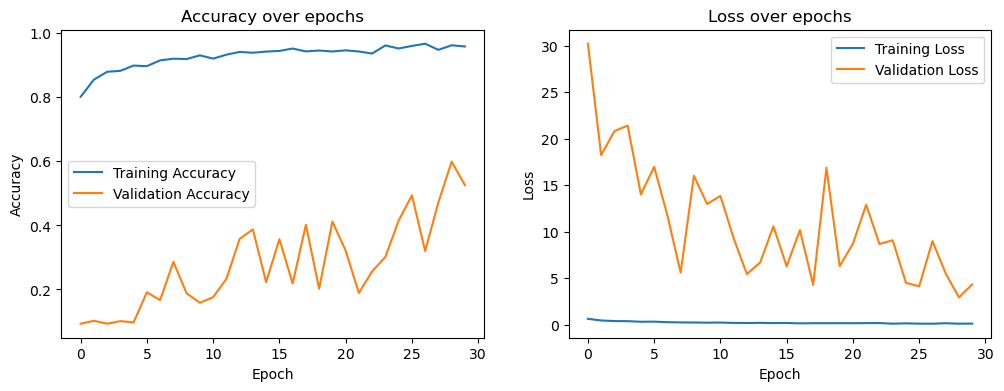

In [9]:
# Epoch별 train/val accuracy와 Loss변화

import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

## 평가 및 시각화


153/153 [==============================] - 63s 402ms/step


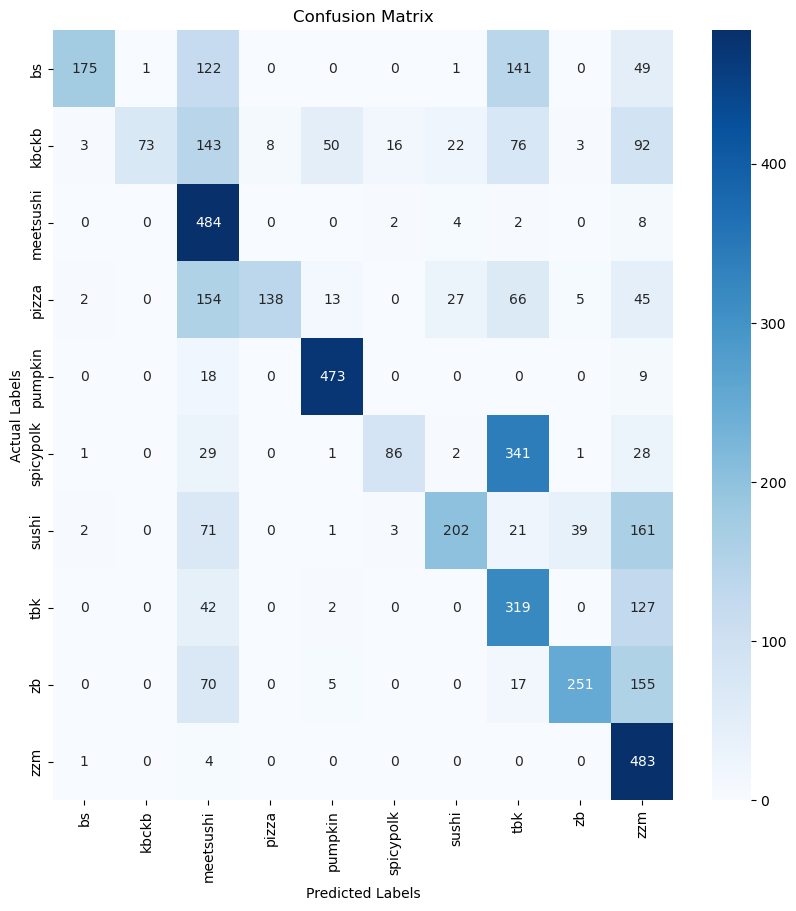

In [11]:
# 평가지표 - 혼동행렬
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_train, y_pred_classes, classes=['bs', 'kbckb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm'])

In [12]:
# 평가지표
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=['bs', 'kbckb', 'meetsushi', 'pizza', 'pumpkin', 'spicypolk', 'sushi', 'tbk', 'zb', 'zzm'])
    print(report)

print_classification_report(y_train, y_pred_classes)

              precision    recall  f1-score   support

          bs       0.95      0.36      0.52       489
       kbckb       0.99      0.15      0.26       486
   meetsushi       0.43      0.97      0.59       500
       pizza       0.95      0.31      0.46       450
     pumpkin       0.87      0.95      0.91       500
   spicypolk       0.80      0.18      0.29       489
       sushi       0.78      0.40      0.53       500
         tbk       0.32      0.65      0.43       490
          zb       0.84      0.50      0.63       498
         zzm       0.42      0.99      0.59       488

    accuracy                           0.55      4890
   macro avg       0.73      0.55      0.52      4890
weighted avg       0.73      0.55      0.52      4890



In [13]:
#모델용량 및 추론시간
import time
import os
import tensorflow.keras.backend as K

def get_model_size(model):
    model.save("temp_model")
    size = os.path.getsize("temp_model") / (1024 * 1024)  # Convert bytes to MB
    os.remove('temp_model')  # Clean up
    return size

def predict_time(model, sample):
    start = time.time()
    model.predict(sample)
    end = time.time()
    return end - start

# 모델 사이즈
model_size = get_model_size(model)
print(f"Model size: {model_size:.2f} MB")

# 샘플당 추론 시간
sample_inference_time = predict_time(model, np.expand_dims(X_test[0], axis=0))
print(f"Sample inference time: {sample_inference_time:.4f} seconds")

INFO:tensorflow:Assets written to: temp_model\assets


INFO:tensorflow:Assets written to: temp_model\assets


PermissionError: [WinError 5] 액세스가 거부되었습니다: 'temp_model'

In [ ]:
# Val Set 예측결과 (50장 무작위 선택, 예측성공 및 예측실패, 예측정확도 표현)
import numpy as np
import matplotlib.pyplot as plt

# 검증 데이터셋에서 무작위로 50장 선택
num_samples = 50
random_indices = np.random.choice(len(X_val), num_samples, replace=False)
sample_images = X_val[random_indices]
sample_labels = y_val[random_indices]

# 예측 수행
predicted_labels = np.argmax(model.predict(sample_images), axis=1)

# 시각화
for i in range(num_samples):
    plt.subplot(5, 10, i+1)
    plt.imshow(sample_images[i])
    plt.axis('off')
    if sample_labels[i] == predicted_labels[i]:
        color = 'green'
    else:
        color = 'red'
    plt.title(classes[predicted_labels[i]], color=color, fontsize=8)

plt.tight_layout()
plt.show()

accuracy = np.sum(sample_labels == predicted_labels) / num_samples
print(f"Accuracy on the sampled images: {accuracy * 100:.2f}%")